# Data Preprocessing

<h2>Table of Contents</h2>

  - [1. Download data](#1.-download-data)
  - [2. Extract data](#2.-extract-data)
  - [3. Transform data](#3.-transform-data)
    - [3.1. Create Target column](#3.1.-create-target-column)
    - [3.2. Data Preprocessing](#3.2.-data-preprocessing)
  - [4. Load data](#4.-load-data)
  - [5. Visualize some plot](#5.-visualize-some-plot)



## 1. Download data

**EEG data for Mental Attention State Detection**

URL: https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/data

In [1]:
import kagglehub
print("Kaggle hub version:", kagglehub.__version__)

# Download latest version
path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

print("Path to dataset files:", path)

Kaggle hub version: 0.3.4
Path to dataset files: C:\Users\thang\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1


In [2]:
# Import Librabies
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# path = "/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1"
files = os.listdir(path)
print(f"Folder: {files}")
for file in files:
    new_path = os.path.join(path, file)
    print(f"Folder {file} has {len(os.listdir(new_path))} files")

Folder: ['EEG Data']
Folder EEG Data has 35 files


In [4]:
# Join file paths and sort
data_path = os.path.join(path, 'EEG Data')
data_files = [os.path.join(data_path, file) for file in os.listdir(data_path) if "record" in file]
data_files.sort(key=lambda x: int(x.split('eeg_record')[1].split('.mat')[0]))
# Verify sorted paths
for file in data_files[:3]:
    print(file) 

C:\Users\thang\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\eeg_record1.mat
C:\Users\thang\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\eeg_record2.mat
C:\Users\thang\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\eeg_record3.mat


## 2. Extract data

According to the dataset's context, the raw data is stored in 'o', and each column in the 'o' data represents a data channel. All of code is implemented in preprocessing module

In [5]:
import sys
sys.path.append('preprocessing')

The raw data is contained in `o.data`, which is an array of size {number-of-samples}x25. Thus, `o.data(:,i)` comprises one data channel, which we will focus on.

In [6]:
from preprocessing.prepare_raw_data import prepare_matlab_file

df = prepare_matlab_file(matlab_file_path=data_files[15-1])
print(df.columns)

Index(['t', 'ED_COUNTER', 'ED_INTERPOLATED', 'ED_RAW_CQ', 'ED_AF3', 'ED_F7',
       'ED_F3', 'ED_FC5', 'ED_T7', 'ED_P7', 'ED_O1', 'ED_O2', 'ED_P8', 'ED_T8',
       'ED_FC6', 'ED_F4', 'ED_F8', 'ED_AF4', 'ED_GYROX', 'ED_GYROY',
       'ED_TIMESTAMP', 'ED_ES_TIMESTAMP', 'ED_FUNC_ID', 'ED_FUNC_VALUE',
       'ED_MARKER', 'ED_SYNC_SIGNAL'],
      dtype='object')


| ID  | Channel Name        | Meaning                                                   |
|-----|---------------------|-----------------------------------------------------------|
| 1   | `'ED_COUNTER'`       | Counter for collected data samples.                       |
| 2   | `'ED_INTERPOLATED'`   | Data interpolation state.                                 |
| 3   | `'ED_RAW_CQ'`         | Raw data quality from sensors.                            |
| 4–17| EEG Channels        | Channels containing EEG data (electroencephalography).    |
| 18  | `'ED_GYROX'`          | Data from gyroscope sensor (X-axis).                      |
| 19  | `'ED_GYROY'`          | Data from gyroscope sensor (Y-axis).                      |
| 20  | `'ED_TIMESTAMP'`      | Timestamp.                                                |
| 21  | `'ED_ES_TIMESTAMP'`   | Event timestamp.                                          |
| 22  | `'ED_FUNC_ID'`        | Function ID code.                                         |
| 23  | `'ED_FUNC_VALUE'`     | Function value.                                           |
| 24  | `'ED_MARKER'`         | Event marker.                                             |
| 25  | `'ED_SYNC_SIGNAL'`    | Synchronization signal.                                   |


And we will take care only channels data

## 3. Transform data

### 3.1. Create Target column

Since the sampling frequency is 128 Hz (128 data points are taken each second), the column `t` represents the sampling times (starting from 0).

According to the dataset's author, during the first 10 minutes of each experiment, the participant is in a `focused` state, the next 10 minutes are in an `unfocused` state, and after that, the participant is in a `drowsy` state.

Therefore, if we convert to sampling times, the formula for the first sample at minute $i$ is $i \times 128 \times 60$, where $128$ is the sampling frequency.

Extract data from columns 4 to 17, representing 14 channels, and then create a `state` column. This step is implemented in data preprocessing stage

### 3.2. Data Preprocessing

The preprocessing of EEG data involves several steps to clean and prepare the data for analysis. The following steps are performed:

1. **Bandpass Filtering**: Apply a bandpass filter to retain important frequencies within the EEG range, typically from 0.5 Hz to 40 Hz, and remove frequencies outside this range.

2. **Line Noise Removal**: Use notch filters to eliminate noise from alternating current (AC) power sources, usually at 50 Hz or 60 Hz, depending on the region.

3. **Re-referencing (Common Average Reference)**: Subtract the mean of all channels from each channel to reduce noise and improve signal quality.

These preprocessing steps help in enhancing the quality of the EEG data, making it more suitable for subsequent analysis and interpretation.

In [ ]:
from preprocessing.filter_eeg import preprocess_eeg_dataframe

# Configuration parameters
fs = 128  # Sampling frequency
lowcut = 0.5  # Low cut-off frequency for band-pass filter
highcut = 40  # High cut-off frequency for band-pass filter

channel_columns = ['ED_AF3', 'ED_F7', 'ED_F3', 'ED_FC5', 'ED_T7', 'ED_P7', 'ED_O1', 'ED_O2', 'ED_P8', 'ED_T8', 'ED_FC6', 'ED_F4', 'ED_F8', 'ED_AF4']
df = df[channel_columns]

In [8]:
filtered_df = preprocess_eeg_dataframe(df, channel_columns)
filtered_df.head()

,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4
0,37.563596,-50.685744,140.055423,-69.255063,-31.215001,10.160328,-5.975149,-23.552903,-17.513367,15.208299,-14.087958,12.143459,20.436554,-23.282476
1,152.663481,-204.111750,563.898195,-278.904145,-124.242003,39.723369,-23.992332,-95.957996,-72.053707,61.882634,-56.257292,49.433238,83.056209,-95.137900
2,239.532724,-315.308944,869.060476,-430.123263,-188.069529,58.047285,-36.601060,-150.592819,-115.314553,96.774939,-85.069801,77.402375,129.989861,-149.727691
3,199.003026,-257.118091,702.420004,-348.468870,-148.852971,43.773885,-29.299423,-123.409328,-98.665749,79.186397,-66.249983,63.487913,106.559125,-122.365933
4,149.422150,-196.610234,531.421196,-264.639439,-113.933299,35.927404,-24.501993,-88.973977,-74.520295,58.723707,-49.945070,47.104776,77.507148,-86.982072


In [9]:
filtered_df.describe()

,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4
count,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,3.591640e+05,359164.000000
mean,0.000170,-0.000102,-0.000015,0.000072,-0.000040,0.000286,-0.000164,0.000004,0.000103,-0.000247,-0.000242,-0.000132,-5.897179e-07,0.000306
std,6.114760,6.362930,9.991744,7.129331,6.458338,9.139658,14.892720,11.609269,7.815827,6.096936,7.232793,5.801847,5.855271e+00,7.367146
min,-166.796566,-315.308944,-281.787757,-430.123263,-188.069529,-64.313871,-222.167372,-150.592819,-128.132934,-64.134590,-362.767406,-63.528719,-8.862905e+01,-149.727691
25%,-3.532687,-3.718494,-5.389564,-4.144899,-3.894354,-5.278460,-6.601765,-6.301759,-4.783957,-3.643921,-3.739842,-3.389838,-3.386327e+00,-4.509564
50%,-0.054516,0.024311,-0.009268,-0.011853,0.033821,0.085779,0.144897,0.089068,0.016966,-0.063046,-0.082286,-0.052975,-5.778202e-02,-0.052211
75%,3.480568,3.740428,5.362570,4.121827,3.887698,5.364475,6.792390,6.441503,4.794177,3.583918,3.679714,3.334758,3.338925e+00,4.465924
max,239.532724,117.574064,869.060476,167.731365,84.247247,73.983790,343.496246,116.184616,87.760061,96.774939,178.074465,77.402375,1.299899e+02,86.582630


## 4. Load data

In [10]:
from preprocessing.prepare_raw_data import extract_data
# function to read data -> add target column -> filter data -> return filtered df

In [11]:
test_df = extract_data(
    prepare_matlab_file(data_files[15-1])
)

f:\CODE\PRML-MidTerm-Project\preprocessing\prepare_raw_data.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_channels.loc[:, "state"] = df_channels.loc[:, "t"].apply(get_state)


In [18]:
test_df.head()

,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4,state
0,0,37.563596,-50.685744,140.055423,-69.255063,-31.215001,10.160328,-5.975149,-23.552903,-17.513367,15.208299,-14.087958,12.143459,20.436554,-23.282476,focused
1,1,152.663481,-204.111750,563.898195,-278.904145,-124.242003,39.723369,-23.992332,-95.957996,-72.053707,61.882634,-56.257292,49.433238,83.056209,-95.137900,focused
2,2,239.532724,-315.308944,869.060476,-430.123263,-188.069529,58.047285,-36.601060,-150.592819,-115.314553,96.774939,-85.069801,77.402375,129.989861,-149.727691,focused
3,3,199.003026,-257.118091,702.420004,-348.468870,-148.852971,43.773885,-29.299423,-123.409328,-98.665749,79.186397,-66.249983,63.487913,106.559125,-122.365933,focused
4,4,149.422150,-196.610234,531.421196,-264.639439,-113.933299,35.927404,-24.501993,-88.973977,-74.520295,58.723707,-49.945070,47.104776,77.507148,-86.982072,focused


In [13]:
test_df.describe()

,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4
count,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,359164.000000,3.591640e+05,359164.000000
mean,179581.500000,0.000170,-0.000102,-0.000015,0.000072,-0.000040,0.000286,-0.000164,0.000004,0.000103,-0.000247,-0.000242,-0.000132,-5.897179e-07,0.000306
std,103681.860379,6.114760,6.362930,9.991744,7.129331,6.458338,9.139658,14.892720,11.609269,7.815827,6.096936,7.232793,5.801847,5.855271e+00,7.367146
min,0.000000,-166.796566,-315.308944,-281.787757,-430.123263,-188.069529,-64.313871,-222.167372,-150.592819,-128.132934,-64.134590,-362.767406,-63.528719,-8.862905e+01,-149.727691
25%,89790.750000,-3.532687,-3.718494,-5.389564,-4.144899,-3.894354,-5.278460,-6.601765,-6.301759,-4.783957,-3.643921,-3.739842,-3.389838,-3.386327e+00,-4.509564
50%,179581.500000,-0.054516,0.024311,-0.009268,-0.011853,0.033821,0.085779,0.144897,0.089068,0.016966,-0.063046,-0.082286,-0.052975,-5.778202e-02,-0.052211
75%,269372.250000,3.480568,3.740428,5.362570,4.121827,3.887698,5.364475,6.792390,6.441503,4.794177,3.583918,3.679714,3.334758,3.338925e+00,4.465924
max,359163.000000,239.532724,117.574064,869.060476,167.731365,84.247247,73.983790,343.496246,116.184616,87.760061,96.774939,178.074465,77.402375,1.299899e+02,86.582630


## 5. Visualize some plot

In [14]:
from preprocessing.visualize import plot_channel_signal

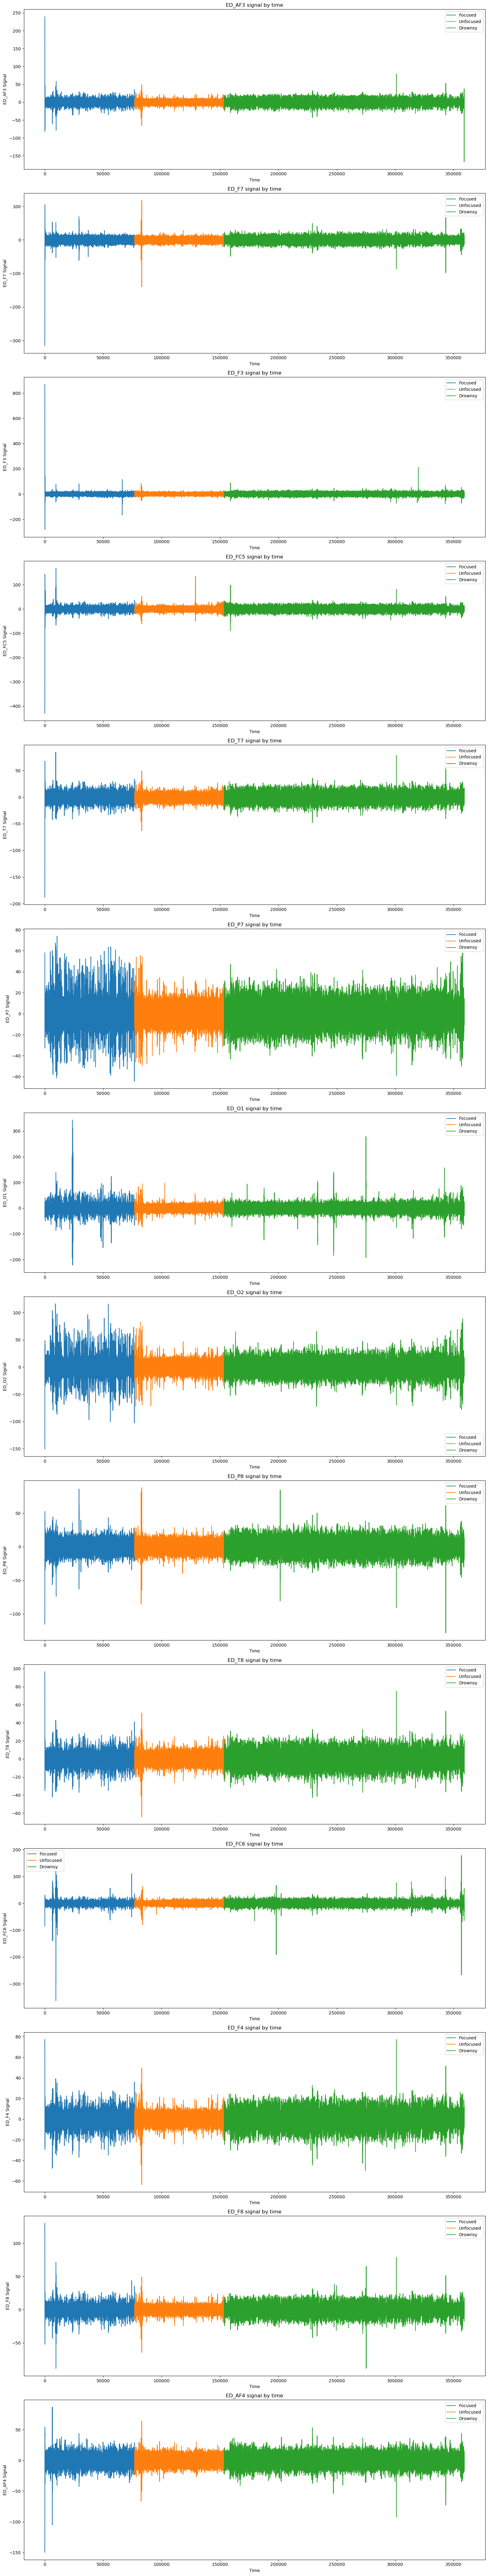

In [15]:
num_channels = len(test_df.columns) - 2
channel_columns = test_df.columns[1:-1]
plt.figure(figsize=(16, 6*num_channels))

for idx, channel in enumerate(channel_columns):
    plt.subplot(num_channels, 1, idx+1)
    plot_channel_signal(test_df, channel)
plt.tight_layout()
plt.show()

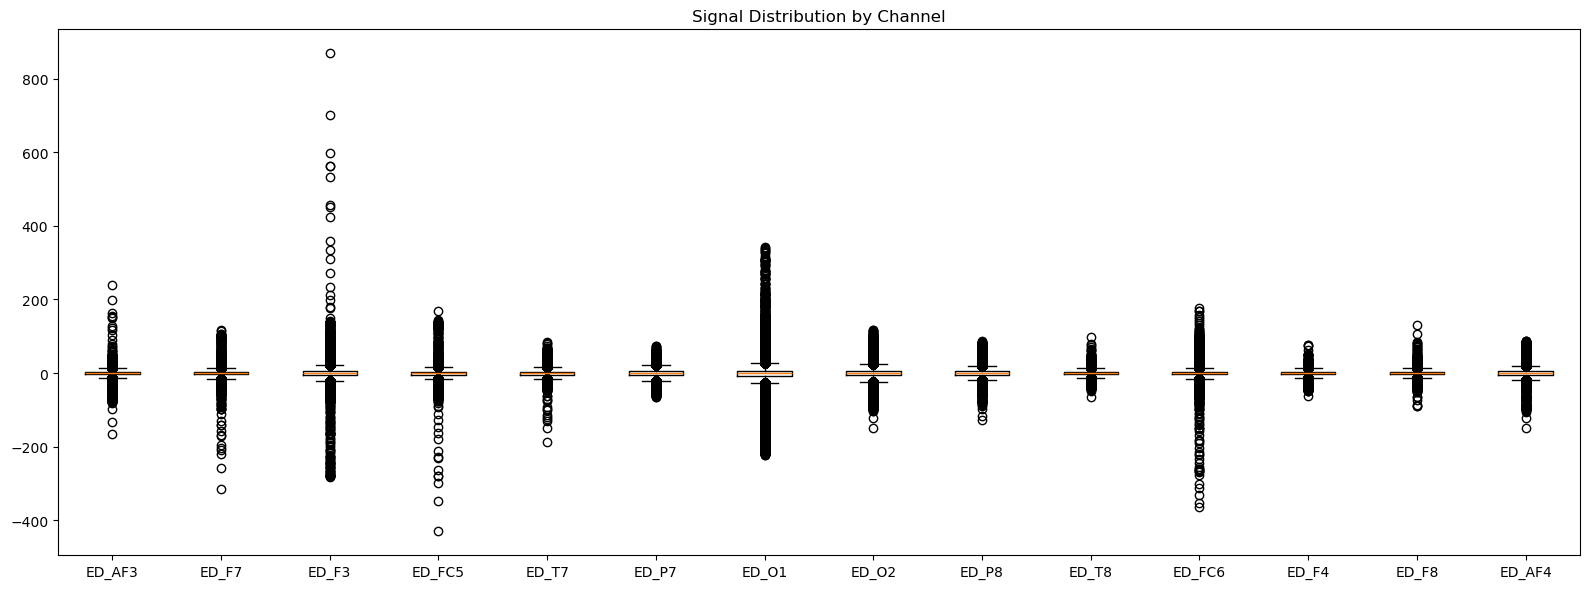

In [16]:
plt.figure(figsize=(16, 6))
plt.boxplot([test_df[column] for column in channel_columns], tick_labels=channel_columns)
plt.title('Signal Distribution by Channel')
plt.tight_layout()
plt.show()

In [17]:
test_df.to_csv("data/preprocessed_eeg15.csv", index=False)